# Survival analysis

**Survival analysis** is a way to describe how long things last.
It is often used to study human lifetimes, but it also applies to "survival" of mechanical and electronic components, or more generally to an interval in time before any kind of event -- or an interval in space.

If someone you know has been diagnosed with a life-threatening disease, you might have seen a "5-year survival rate," which is the probability of surviving five years after diagnosis.
This chapter introduces the tools and methods used to produce estimates like that.

We'll start with a relatively simple example, the lifespans of light bulbs, and then consider a more substantial example, age at first marriage and how it has changed in the United States over the last 50 years.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/nb/chap13.ipynb).

In [93]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [94]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [95]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

## Survival Function

A fundamental concept in survival analysis is the **survival function** which is the fraction of a population that survives longer than a given duration.
As a first example, we'll compute a survival function for the lifespans of light bulbs.

We'll use data from an experiment conducted in 2007 -- researchers installed 50 new light bulbs and left them on continuously.
Checking on the bulbs every 12 hours, they recorded the lifespan of all 50 bulbs.
Instructions for downloading the data are in the notebook for this chapter.

The following cell downloads the data, which is documented [here](https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1).

Dataset from:
    
V.J. Menon and D.C. Agrawal,  Renewal Rate of Filament Lamps: 
Theory and Experiment. Journal of Failure Analysis and Prevention. 
December 2007, p. 421, Table 2/
DOI: 10.1007/s11668-007-9074-9

In [97]:
download(
    "https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1/raw/c932bc5b6aa6317770c4cbf43eb591511fec08f9/lamps.csv"
)

<IPython.core.display.Javascript object>

We can read the data like this.

In [98]:
df = pd.read_csv("lamps.csv", index_col=0)
df.tail()

,h,f,K
i,,,
28,1812,1,4
29,1836,1,3
30,1860,1,2
31,1980,1,1
32,2568,1,0


<IPython.core.display.Javascript object>

The `h` column contains the lifespans in hours.
The `f` column contains counts of the number of bulbs that expired at each value of `h`.
To represent the distribution of lifespans, we'll put these values in a `Pmf` object and normalize it.

In [99]:
from empiricaldist import Pmf

pmf_bulblife = Pmf(df["f"].values, index=df["h"])
pmf_bulblife.normalize()

50

<IPython.core.display.Javascript object>

We can use `make_cdf` to compute the CDF, which indicates the fraction of bulbs that expire at or before each value of `h`.
For example, 78% of the bulbs expire at or before 1656 hours.

In [100]:
cdf_bulblife = pmf_bulblife.make_cdf()
cdf_bulblife[1656]

0.7800000000000002

<IPython.core.display.Javascript object>

The survival function is fraction of bulbs that expire *after* each value of `h`, which is the complement of the CDF.
So we can compute it like this.

In [101]:
complementary_cdf = 1 - cdf_bulblife
complementary_cdf[1656]

0.21999999999999975

<IPython.core.display.Javascript object>

22% of the bulbs expire after 1656 hours.

The `empiricaldist` library provides a `Surv` object that represents a survival function, and a method called `make_surv` that makes one.

In [102]:
surv_bulblife = cdf_bulblife.make_surv()
surv_bulblife[1656]

0.21999999999999997

<IPython.core.display.Javascript object>

If we plot the CDF and the survival function, we can see that they are complementary -- that is, their sum is 1 at all values of `h`.

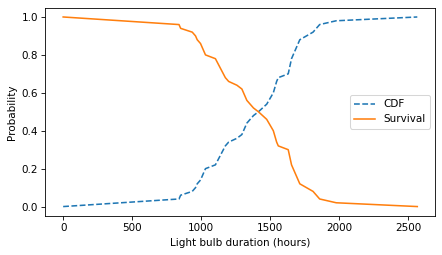

<IPython.core.display.Javascript object>

In [103]:
cdf_bulblife.plot(ls="--", label="CDF")
surv_bulblife.plot(label="Survival")

decorate(xlabel="Light bulb duration (hours)", ylabel="Probability")

In that sense, the CDF and survival function are equivalent -- if we are given either one, we can compute the other.
But in the context of survival analysis it is more common to work with survival curves.
And computing a survival curve is a step toward the next important concept, the hazard function.

## Hazard Function

Suppose we know that a light bulb has survived up to hour `h`, and we would like to know the probability that it expires during hour `h`.
To answer this question, we can use the survival function, which indicates the fraction of bulbs that survive longer than `h`, and the PMF, which indicates the fraction that expire during hour `h`.
The sum of these is the fraction of bulbs that *could* expire during hour `h`, which are said to be "at risk".
As an example, 26% of the bulbs were at risk during hour 1656.

In [104]:
at_risk = pmf_bulblife + surv_bulblife
at_risk[1656]

0.25999999999999995

<IPython.core.display.Javascript object>

And 4% of all bulbs expire during hour 1656.

In [105]:
pmf_bulblife[1656]

0.04

<IPython.core.display.Javascript object>

The **hazard** is the ratio of `pmf_bulblife` and `at_risk`.

In [106]:
hazard = pmf_bulblife / at_risk
hazard[1656]

0.15384615384615388

<IPython.core.display.Javascript object>

Of all bulbs that survived up to hour 1656, about 15% expired during hour 1656.

Instead of computing the hazard function ourselves, we can use `empiricaldist`, which provides a `Hazard` object that represents a hazard function, and a `make_hazard` method that computes it.

In [107]:
hazard_bulblife = surv_bulblife.make_hazard()
hazard_bulblife[1656]

0.15384615384615397

<IPython.core.display.Javascript object>

Here's what the hazard function looks like for the light bulbs.

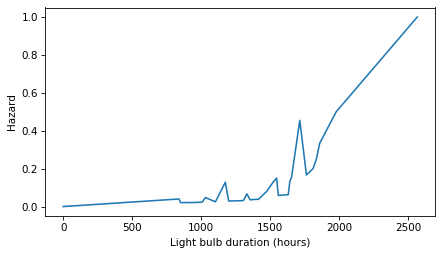

<IPython.core.display.Javascript object>

In [108]:
hazard_bulblife.plot()
decorate(xlabel="Light bulb duration (hours)", ylabel="Hazard")

We can see that the hazard is higher in some places than others, but this way of visualizing the hazard function can be misleading, especially in parts of the range where we don't have much data.
A better alternative is to plot the cumulative hazard function, which is the cumulative sum of the hazards.

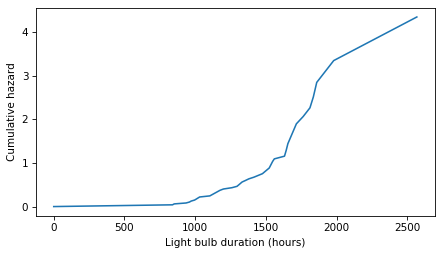

<IPython.core.display.Javascript object>

In [109]:
cumulative_hazard = hazard_bulblife.cumsum()
cumulative_hazard.plot()

decorate(xlabel="Light bulb duration (hours)", ylabel="Cumulative hazard")

Where the probability of expiring is high, the cumulative hazard function is steep.
Where the probability of expiring is low, the cumulative hazard function is flat.
In this example, we can see that the interval with the highest hazards is between 1500 an 2000 hours.
After that, the hazards are actually a little lower -- although this outcome is based on just one unusually long-lived battery, so it might look different in another dataset.

Now that we have the general idea of survival and hazard functions, let's apply them to a more substantial dataset.

## Marriage Data

In many other countries, people are getting married later than they used to, and more people stay unmarried.
To explore these trends in the United States, we'll use the tools of survival analysis and data from the National Survey of Family Growth (NSFG).

The NSFG dataset we used in previous chapters is the pregnancy file, which contains one row for each pregnancy reported by the survey respondents.
In this chapter, we'll work with the respondent file, which contains information about the respondents themselves.

I have compiled responses from nine iterations of the survey, conducted between 1982 and 2019, and selected data related to marriage.
Instructions for downloading this excerpt are in the notebook for this chapter. 

The following cell downloads the data, which is a CSV file I created that combines data from several iterations of the NSFG survey, from 1982 to 2019.

Details of the data preparation are in [this notebook](https://github.com/AllenDowney/MarriageNSFG/blob/master/clean_nsfg.ipynb).

In [110]:
filename = "marriage_nsfg_female.csv.gz"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)

<IPython.core.display.Javascript object>

We can read the data like this.

In [111]:
resp = pd.read_csv("marriage_nsfg_female.csv.gz")
resp.shape

(70183, 34)

<IPython.core.display.Javascript object>

The excerpt includes one row for each of more than 70,000 respondents, and includes the following variables related to age and marriage.

-   `cmbirth`: The respondent's date of birth, known for all respondents.

-   `cmintvw`: The date the respondent was interviewed, known for all respondents.

-   `cmmarrhx`: The date the respondent was first married, if applicable and known.

-   `evrmarry`: 1 if the respondent had been married prior to the date of interview, 0 otherwise.

The first three variables are encoded in "century-months" -- that is, the integer number of months since December 1899.
So century-month 1 is January 1900.

To explore generational changes, we will group respondents by their decade of birth.
We'll use the following function, which takes a value of `cmbirth` and computes the corresponding decade of birth.

In [112]:
month0 = pd.to_datetime("1899-12-31")


def decade_of_birth(cmbirth):
    date = month0 + pd.DateOffset(months=cmbirth)
    return date.year // 10 * 10

<IPython.core.display.Javascript object>

We can use this function and the `apply` method to compute each respondent's decade of birth and assign it to a new column called `cohort`.
In this context, a **cohort** is a group of people with something in common -- like they decade they were born -- who are treated as a group for purposes of analysis.

The result from `value_counts` shows the number of people in each cohort.

In [113]:
from thinkstats import value_counts

resp["cohort"] = resp["cmbirth"].apply(decade_of_birth)
value_counts(resp["cohort"])

cohort
1930      325
1940     3608
1950    10631
1960    14953
1970    16438
1980    14271
1990     8552
2000     1405
Name: count, dtype: int64

<IPython.core.display.Javascript object>

We have more than 10,000 respondents born in each decade from the 1950s to the 1980s, and fewer respondents in the earlier and later decades.

Next we'll compute each respondent's age when married (if applicable) and their age when interviewed.

In [114]:
resp["agemarr"] = (resp["cmmarrhx"] - resp["cmbirth"]) / 12
resp["age"] = (resp["cmintvw"] - resp["cmbirth"]) / 12

<IPython.core.display.Javascript object>

To get started with this data, we'll use the following function, which takes as parameters the dataset and a list of cohorts.
For each cohort, it selects their ages at first marriage and uses to compute a survival function.
The `dropna=False` argument tells `Surv.from_seq` to include `NaN` values in the survival function, so the result includes people who have not married.

The function returns a dictionary that maps from each integer cohort to a `Surv` object.
Note: This function is not correct -- in later sections we'll see what the problem is and fix it.

In [115]:
from empiricaldist import Surv


def make_survival_map(resp, cohorts):
    surv_map = {}

    grouped = resp.groupby("cohort")
    for cohort in cohorts:
        group = grouped.get_group(cohort)
        surv_map[cohort] = Surv.from_seq(group["agemarr"], dropna=False)

    return surv_map

<IPython.core.display.Javascript object>

Here's how we use this function.

In [116]:
cohorts = [1980, 1960, 1940]
surv_map = make_survival_map(resp, cohorts)

<IPython.core.display.Javascript object>

And here are the results for people born in the 1940s, 1960s, and 1980s.

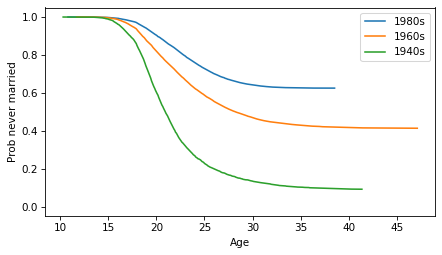

<IPython.core.display.Javascript object>

In [117]:
for cohort, surv in surv_map.items():
    surv.plot(label=f"{cohort}s")

decorate(xlabel="Age", ylabel="Prob never married", ylim=[-0.05, 1.05])

If we take these results at face value, they show that people in earlier generations got married younger, and more of them got married.
However, we should not interpret these results yet, because they are not correct.
There are two problems we have to address:

* As discussed in Section XXX, the NSFG uses stratified sampling, which means that it deliberated oversamples some groups.

* This way of computing the survival function does not properly take into account people who are not married yet.

For the first problem, we have already seen a solution, weighted resampling.
For the second problem, we will need a new method, Kaplan-Meier estimation.
We'll start with resampling.

## Weighted Resampling

The NSFG dataset includes a column called `finalwgt` that contains each respondent's sampling weight, which is the number of people in the population they represent.
We can use these weights during the resampling process to correct for stratified sampling.
Here's the function from Section XXX that does it.

In [118]:
def resample_rows_weighted(df, column="finalwgt"):
    n = len(df)
    weights = df[column]
    return df.sample(n, weights=weights, replace=True)

<IPython.core.display.Javascript object>

The current dataset includes respondents from several iterations of the survey, called cycles, so in order to resample, we have to group the respondents by cycle, resample each group, and then put the groups back together.
That's what the following function does.

In [119]:
def resample_cycles(resp):
    grouped = resp.groupby("cycle")
    samples = [resample_rows_weighted(group) for _, group in grouped]
    return pd.concat(samples)

<IPython.core.display.Javascript object>

To get started, we'll resample the data once.

In [120]:
sample = resample_cycles(resp)

<IPython.core.display.Javascript object>

Later we'll resample the data several times, so we can see how much variation there is due to random sample.

The following figure shows the results with resampling, compared to the results from the previous section without resampling, shown as dotted lines.

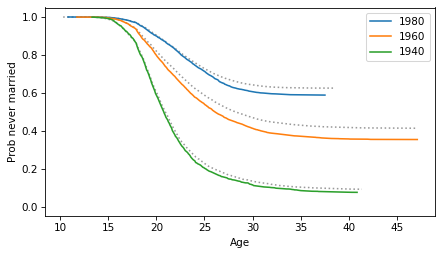

<IPython.core.display.Javascript object>

In [121]:
for label, surv in surv_map.items():
    surv.plot(ls=":", color="gray", alpha=0.8)

survs_resampled = make_survival_map(sample, cohorts)

for label, surv in survs_resampled.items():
    surv.plot(label=label)

decorate(xlabel="Age", ylabel="Prob never married", ylim=[-0.05, 1.05])

The difference, with and without resampling, is substantial, which shows that we need to correct for stratified sampling to get accurate results.

Now let's get to the second problem, dealing with incomplete data.

## Estimating Survival Functions

In the light bulb example, we know the life spans for all 50 bulbs, so we can compute the survival function directly -- and we can use the survival function to compute the hazard function.

In the marriage example, we know the age at first marriage for some respondents, the ones who had been married before they were interviewed.
But for respondents who had had never married before they were interviewed, we don't know at what age they will marry in the future -- or if they will.

This kind of missing data is said to be **censored**.
That term might seem odd, because censored information is usually hidden deliberately, but in this case it is hidden just because we don't know the future.

However, in this case we have partial information we can work with: if someone is unmarried when they are surveyed, we know that the age when they get married (if they do) must be greater than their current age.

We can use this partial information to estimate the hazard function; then we can use the hazard function to compute the survival function.
This process is called **Kaplan-Meier estimation**.

To demonstrate, I'll select just one cohort from the resampled data.

In [122]:
resp60 = sample.query("cohort == 1960")

<IPython.core.display.Javascript object>

For respondents who were married when they were surveyed, we'll select their age at first marriage.
There are 10,222 of them, which we'll call "completed" cases.

In [123]:
complete = resp60.query("evrmarry == 1")["agemarr"]
complete.count()

9830

<IPython.core.display.Javascript object>

For respondents who had not married, we'll select their age when they were surveyed.
There are 5,501 of them, which we'll call the "ongoing" cases.

In [124]:
ongoing = resp60.query("evrmarry == 0")["age"]
ongoing.count()

5352

<IPython.core.display.Javascript object>

Now, to estimate the hazard function, we'll compute the total number of cases that were "at risk" at each age, including everyone who was unmarried up to that age.
It will be convenient to make a `Hist` object that counts the number of complete and ongoing cases at each age.

In [125]:
from empiricaldist import Hist

hist_complete = Hist.from_seq(complete)
hist_ongoing = Hist.from_seq(ongoing)

<IPython.core.display.Javascript object>

As an example, there are 87 respondents who reported that they were married for the first time at age 25.

In [126]:
hist_complete[25]

72

<IPython.core.display.Javascript object>

And another 13 respondents who were surveyed at age 25 and reported that they had never married.

In [127]:
hist_ongoing[25]

6

<IPython.core.display.Javascript object>

From these `Hist` objects, we can compute unnormalized `Surv` objects that contain the number of complete and ongoing cases that exceed each age.

In [128]:
surv_complete = hist_complete.make_surv()
surv_ongoing = hist_ongoing.make_surv()

<IPython.core.display.Javascript object>

For example, there are 2937 people who reported getting married after age 25.

In [129]:
surv_complete[25]

2829

<IPython.core.display.Javascript object>

And 2306 people surveyed after age 25 who had never married.

In [130]:
surv_ongoing[25]

2184

<IPython.core.display.Javascript object>

The sum of the four numbers we just computed is the number of respondents who were "at risk" -- that is, people who could have married at age 25.

In [131]:
at_risk = hist_complete[25] + hist_ongoing[25] + surv_complete[25] + surv_ongoing[25]
at_risk

5091

<IPython.core.display.Javascript object>

Of those, the number who actually married at age 25 is `hist_complete[25]`.
So we can compute the hazard function at age 25 like this.

In [132]:
hazard = hist_complete[25] / at_risk
hazard

0.014142604596346494

<IPython.core.display.Javascript object>

That's how we can compute the hazard function at a single age.
Now let's compute the whole function, for all ages.
We'll use the `union` method of the `Index` class to compute a Pandas `Index` that contains all of the ages from `hist_complete` and `hist_ongoing`, in order.

In [133]:
ts = pd.Index.union(hist_complete.index, hist_ongoing.index)

<IPython.core.display.Javascript object>

Now we can compute the number of people at risk at every age, by looking up the ages in `ts` in each of the  `Hist` and `Surv` objects.

In [134]:
at_risk = hist_complete(ts) + hist_ongoing(ts) + surv_complete(ts) + surv_ongoing(ts)

<IPython.core.display.Javascript object>

Finally, we can compute the hazard function at each age, and put the results into a `Hazard` object.

In [135]:
from empiricaldist import Hazard

hs = hist_complete(ts) / at_risk
hazard = Hazard(hs, ts)

<IPython.core.display.Javascript object>

Here's what the cumulative hazard function looks like.

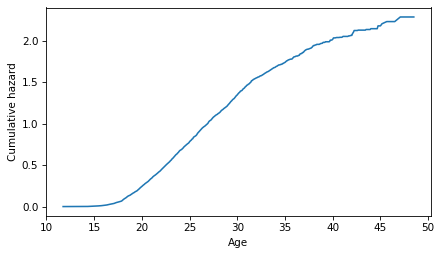

<IPython.core.display.Javascript object>

In [136]:
hazard.cumsum().plot()

decorate(xlabel="Age", ylabel="Cumulative hazard")

The cumulative hazard function is steepest between ages 20 and 30, which means that an unmarried person is in the greatest "danger" of getting married at these ages.
After that, the hazard gradually decreases.

## Estimating the Survival Function

If we are given a survival function, we know how to compute the hazard function.
Now let's go in the other direction.

Here's one way of thinking of it.
The hazard function indicates the probability of getting married at each age, if you have not already married.
So the complement of the hazard function if the probability of staying unmarried at each age.

In order to "survive" past a given age, `t`, you have at stay unmarried at every age up to and including `t`.
And the probability of doing that is the product of the complementary hazard function, which we can compute like this.

In [137]:
ps = (1 - hazard).cumprod()

<IPython.core.display.Javascript object>

The `Hazard` object has a `make_surv` method that does this computation.

In [138]:
surv = hazard.make_surv()

<IPython.core.display.Javascript object>

Here's what the result looks like, compared to the previous result (dotted line), which corrected for stratified resampling, but did not handle censored data.

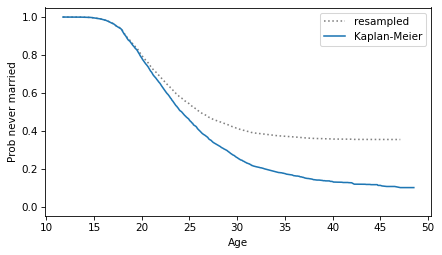

<IPython.core.display.Javascript object>

In [139]:
survs_resampled[1960].plot(ls=":", color="gray", label="resampled")
surv.plot(label="Kaplan-Meier")

decorate(xlabel="Age", ylabel="Prob never married", ylim=[-0.05, 1.05])

We can see how important it is to handle censored data correctly.

A survival function like this was the basis of a famous magazine article in 1986 -- *Newsweek* reported that a 40-year old unmarried woman was "more likely to be killed by a terrorist" than get married.
That claim was widely reported and became part of popular culture, but it was wrong then (because it was based on faulty analysis) and turned out to be even more wrong (because of cultural changes that were already in progress and continued).
In 2006, *Newsweek* ran an another article admitting that they were wrong.

I encourage you to read more about this article, the statistics it was based on, and the reaction.
It should remind you of the ethical obligation to perform statistical analysis with care, interpret the results with appropriate skepticism, and present them to the public accurately and honestly.

[Snopes has a good article on the topic](https://www.snopes.com/fact-check/marry-go-round/).

The following function encapsulates the steps of Kaplan-Meier estimation.
It takes as arguments sequences of survival times for complete and ongoing cases, and returns a `Hazard` object.

In [140]:
def estimate_hazard(complete, ongoing):
    """Kaplan-Meier estimation."""
    hist_complete = Hist.from_seq(complete)
    hist_ongoing = Hist.from_seq(ongoing)

    surv_complete = hist_complete.make_surv()
    surv_ongoing = hist_ongoing.make_surv()

    ts = pd.Index.union(hist_complete.index, hist_ongoing.index)
    at_risk = (
        hist_complete(ts) + hist_ongoing(ts) + surv_complete(ts) + surv_ongoing(ts)
    )

    hs = hist_complete(ts) / at_risk
    return Hazard(hs, ts)

<IPython.core.display.Javascript object>

And here's a function that takes a group of respondents, extracts survival times, calls `estimate_hazard` to get the hazard function, and then computes the corresponding survival function.

In [141]:
def estimate_survival(group):
    """Estimate the survival function."""
    complete = group.query("evrmarry == 1")["agemarr"]
    ongoing = group.query("evrmarry == 0")["age"]
    hf = estimate_hazard(complete, ongoing)
    sf = hf.make_surv()
    return sf

<IPython.core.display.Javascript object>

In the next section, we'll use these functions to compute confidence intervals for survival functions.

## Lifelines

A Python package called `lifelines` provides tools for survival analysis, including functions that compute Kaplan-Meier estimates.

The following cell installs `lifelines` if necessary.

In [193]:
try:
    import lifelines
except ImportError:
    !pip install lifelines

<IPython.core.display.Javascript object>

We can use it to confirm that the result in the previous section is correct.
First we'll compute the survival function using `estimate_survival`.

In [143]:
surv = estimate_survival(resp60)

<IPython.core.display.Javascript object>

Next we'll compute it using `lifelines`.
First we'll get the data into the format `lifelines` requires.

In [144]:
complete = complete.dropna()
durations = np.concatenate([complete, ongoing])
event_observed = np.concatenate([np.ones(len(complete)), np.zeros(len(ongoing))])

<IPython.core.display.Javascript object>

Now we can make a `KaplanMeierFitter` object and fit the data.

In [145]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(durations=durations, event_observed=event_observed)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 15182 total observations, 5352 right-censored observations>

<IPython.core.display.Javascript object>

After fitting the data, we can call the `plot` function to display the results, which include the estimated survival function and a confidence interval -- although the confidence interval is not correct in this case because it doesn't correct for stratified sampling.

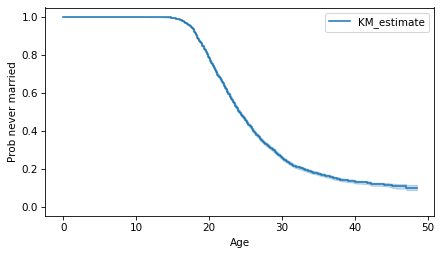

<IPython.core.display.Javascript object>

In [190]:
kmf.plot()

decorate(xlabel="Age", ylabel="Prob never married", ylim=[-0.05, 1.05])

The results from lifelines are slightly different from the results we computed because they start from 0.
But all of the other values are the same, within floating-point error.

In [147]:
ps = kmf.survival_function_["KM_estimate"].drop(0)
np.allclose(ps, surv)

True

<IPython.core.display.Javascript object>

In the next section, we'll use weighted resampling to compute confidence intervals that take stratified sampling into account.

## Confidence Intervals

The Kaplan-Meier estimate we computed is based on a single resampling of the dataset.
To get an idea of how much variation there is due to random sampling, we'll run the analysis with several resamplings and plot the results.

We'll use the following function, which takes a `DataFrame` and a list of cohorts, estimates the survival function for each cohort, and returns a dictionary that maps from each integer cohort to a `Surv` object.

This function is identical to `make_survival_map` in Section xxx, except that it calls `estimate_survival`, which uses Kaplan-Meier estimation, rather than `Surv.from_seq`, which only works if there is no censored data.

In [148]:
def estimate_survival_map(resp, cohorts):
    """Make a dictionary from cohorts to Surv objects."""
    surv_map = {}

    grouped = resp.groupby("cohort")
    for cohort in cohorts:
        group = grouped.get_group(cohort)
        surv_map[cohort] = estimate_survival(group)

    return surv_map

<IPython.core.display.Javascript object>

The following loop generates 101 random resamplings of the dataset and makes a list of 101 dictionaries containing the estimated survival functions.

In [149]:
cohorts = [1940, 1950, 1960, 1970, 1980, 1990]

surv_maps = [estimate_survival_map(resample_cycles(resp), cohorts) for i in range(101)]

<IPython.core.display.Javascript object>

To plot the results, we'll use the following function, which takes that list of dictionaries, an integer cohort, and a color string.
It loops through the dictionaries, selects the survival function for the given cohort, and plots it with a nearly transparent line -- which is one way to visualize the variability between resamplings.

In [150]:
def plot_cohort(surv_maps, cohort, color):
    """Plot results for a single cohort."""
    survs = [surv_map[cohort] for surv_map in surv_maps]
    for surv in survs:
        surv.plot(color=color, alpha=0.05)

    x, y = surv.index[-1], surv.iloc[-1]
    plt.text(x + 1, y, f"{cohort}s", ha="left", va="center")

<IPython.core.display.Javascript object>

Here are the results for birth cohorts from the 1940s to the 1990s.

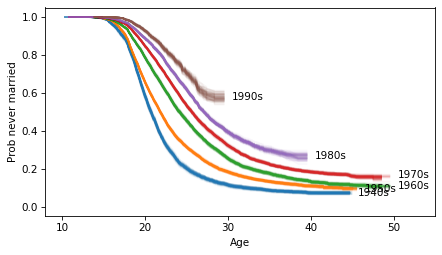

<IPython.core.display.Javascript object>

In [191]:
colors = [f"C{i}" for i in range(len(cohorts))]

for cohort, color in zip(cohorts, colors):
    plot_cohort(surv_maps, cohort, color)

decorate(xlabel="Age", ylabel="Prob never married", xlim=[8, 55], ylim=[-0.05, 1.05])

Several patterns are visible:

-   Women born in the 1940s married earliest -- cohorts born in the 1950s and 1960s married later, but about the same fraction stayed unmarried.

-   Women born in the 1970s married later *and* stayed unmarried at higher rates than previous cohorts.

-   Cohorts born in 1980s, and 1990s are marrying even later, and are on track to stay unmarried at even higher rates -- although these patterns could change in the future.

We'll have to wait for the next data release from the NSFG to learn more.

## Expected Remaining Lifetime

Given a distribution, we can compute the expected remaining lifetime as a function of elapsed time.
For example, given the distribution of pregnancy lengths, we can compute the expected time until delivery.
To demonstrate, we'll use pregnancy data from the NSFG.

The following cells download the data files and install `statadict`, which we need to read the data.

In [152]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

<IPython.core.display.Javascript object>

In [153]:
try:
    import statadict
except ImportError:
    !pip install statadict

<IPython.core.display.Javascript object>

We can load it like this.

In [154]:
from nsfg import get_nsfg_groups

live, firsts, others = get_nsfg_groups()

<IPython.core.display.Javascript object>

We'll start with a single resampling of the data.

In [155]:
sample = resample_rows_weighted(live, "finalwgt")

<IPython.core.display.Javascript object>

Here's the PMF of pregnancy durations.

In [156]:
pmf_durations = Pmf.from_seq(sample["prglngth"])

<IPython.core.display.Javascript object>

Now suppose it's the beginning of the 36th week of pregnancy.
Remembering that the most common pregnancy length is 39 weeks, we expect the remaining time to be 3-4 weeks.
To make that estimate more precise, we can identify the values in the distribution that equal or exceed 36 weeks.

In [157]:
t = 36
is_remaining = pmf_durations.qs >= t

<IPython.core.display.Javascript object>

Next we'll make a new `Pmf` object that contains only those values, shifted left so the current time is at 0.

In [ ]:
ps = pmf_durations.ps[is_remaining]
qs = pmf_durations.qs[is_remaining] - t

pmf_remaining = Pmf(ps, qs)

Because we selected a subset of the values in the `Pmf`, the probabilities no longer add up to 1, but we can normalize the `Pmf` so they do.

In [158]:
pmf_remaining.normalize()

<IPython.core.display.Javascript object>

Here's the result, which shows the distribution of remaining time at the beginning of the 36th week.

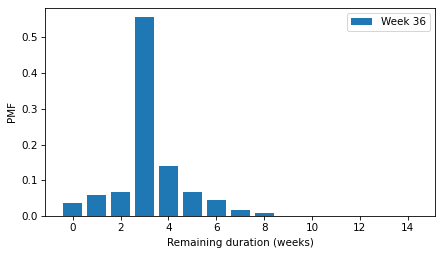

<IPython.core.display.Javascript object>

In [160]:
pmf_remaining.bar(label="Week 36")
decorate(xlabel="Remaining duration (weeks)", ylabel="PMF")

The mean of this distribution is the expected remaining time.

In [161]:
pmf_remaining.mean()

3.2389929602672716

<IPython.core.display.Javascript object>

The following function encapsulates these steps and computes the distribution of remaining time for a given `Pmf` at a given time, `t`.

In [194]:
def compute_pmf_remaining(pmf, t):
    """Distribution of remaining time."""
    is_remaining = pmf.qs >= t
    ps = pmf.ps[is_remaining]
    qs = pmf.qs[is_remaining] - t
    pmf_remaining = Pmf(ps, qs)
    pmf_remaining.normalize()
    return pmf_remaining

<IPython.core.display.Javascript object>

The following function takes a `Pmf` of pregnancy lengths and computes the expected remaining time at the beginning of each week from the 36th to the 43rd. 

In [163]:
def expected_remaining(pmf):
    index = range(36, 44)
    expected = pd.Series(index=index)

    for t in index:
        pmf_remaining = compute_pmf_remaining(pmf, t)
        expected[t] = pmf_remaining.mean()

    return expected

<IPython.core.display.Javascript object>

Here are the results for a single resampling of the data.

In [164]:
expected = expected_remaining(pmf_durations)
expected

36    3.238993
37    2.364650
38    1.519878
39    0.643153
40    0.920682
41    0.854811
42    0.636513
43    0.619247
dtype: float64

<IPython.core.display.Javascript object>

To see how much variation there is due to random sampling, we can run this analysis with several resamplings and plot the results.

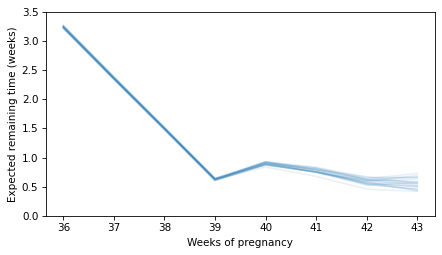

<IPython.core.display.Javascript object>

In [195]:
for i in range(21):
    sample = resample_rows_weighted(live, "finalwgt")
    pmf_durations = Pmf.from_seq(sample["prglngth"])
    expected = expected_remaining(pmf_durations)
    expected.plot(color="C0", alpha=0.1)

decorate(
    xlabel="Weeks of pregnancy", ylabel="Expected remaining time (weeks)", ylim=[0, 3.5]
)

Between weeks 36 and 39, the expected remaining time decreases until, at the beginning of the 39th week, it is about 0.5 weeks.
But after that, the curve levels off.
At the beginning of the 40th week, the expected remaining time is still close to 0.5 week, and at the beginning of the 41st, 42nd, and 43rd, it is almost the same.
For people waiting anxiously for a baby to be born, this behavior seems quite cruel.

## Glossary

-   **survival analysis**: A set of methods for describing and predicting lifetimes, or more generally time until an event occurs.

-   **survival function**: A function that maps from a time, $t$, to the probability of surviving past $t$.

-   **hazard function**: A function that maps from $t$ to the fraction of people alive until $t$ who die at $t$.

-   **censored data**: Data that is only partially known, often because it depends on future events.

-   **Kaplan-Meier estimation**: An algorithm for estimating hazard and survival functions.

-   **cohort**: A group of subjects with something in common -- like they decade they were born -- who are treated as a group for purposes of analysis.

## Exercises

### Exercise

We can use the methods in this chapter to estimate hazard and survival functions for the duration of a marriage.
To keep things simple, we'll consider only first marriages, and we'll focus on divorce as the endpoint, rather than separation or death. 

In the NSFG data, the `cmdivorcx` column contains the date of divorce for each respondent's first marriage, if applicable, encoded in century-months.
Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing.

* For complete cases, compute the elapsed time between `cmdivorcx` and `cmmarrhx`. If both values are valid -- not `NaN` -- that means the respondent's first marriage ended in divorce.

* To identify ongoing cases, select people who have only married once and who are still married. You can use `fmarno`, which records the number of times each respondent has married, and `fmarital`, which encodes their marital status -- the value 1 indicates that the respondent is married.

In some cases the values of these variables are only approximate, so you might find a small number of negative differences, but they should not be more than one year.

Estimate the hazard and survival functions for the duration of marriage.
Plot the cumulative hazard function -- when is the danger of divorce highest?
Plot the survival function -- what fraction of marriages end in divorce?

In [196]:
# I suggest you use a single resampling of the data

sample = resample_cycles(resp)

<IPython.core.display.Javascript object>

In [197]:
# Solution

complete = (sample["cmdivorcx"] - sample["cmmarrhx"]) / 12
complete.describe()

count    9948.000000
mean        6.443900
std         4.814054
min         0.000000
25%         2.750000
50%         5.250000
75%         9.000000
max        26.750000
dtype: float64

<IPython.core.display.Javascript object>

In [198]:
# Solution

still_married = sample.query("fmarno == 1 and rmarital == 1")
ongoing = (still_married["cmintvw"] - still_married["cmmarrhx"]) / 12
ongoing.describe()

count    26297.000000
mean        10.285134
std          6.959709
min         -0.250000
25%          4.416667
50%          9.250000
75%         15.416667
max         32.916667
dtype: float64

<IPython.core.display.Javascript object>

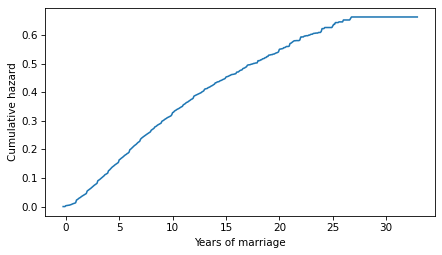

<IPython.core.display.Javascript object>

In [199]:
# Solution

# The hazard function is almost flat in the first year, indicating that the
# hazard is relatively low.
# The curve is steeper after that, with the highest hazard in the next few years,
# and gradually decreasing thereafter.

hazard = estimate_hazard(complete, ongoing)
hazard.cumsum().plot()

decorate(xlabel="Years of marriage", ylabel="Cumulative hazard")

In [200]:
# Solution

surv = hazard.make_surv()

<IPython.core.display.Javascript object>

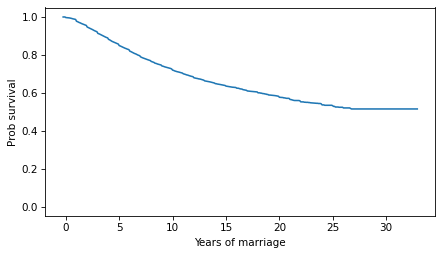

<IPython.core.display.Javascript object>

In [201]:
# Solution

# It looks like almost 50% of marriages end in divorce, which is consistent
# with a commonly quoted but seldom attributed statistic.

surv.plot()
decorate(xlabel="Years of marriage", ylabel="Prob survival", ylim=[-0.05, 1.05])

In [202]:
# Solution

# The exercise did not ask for a breakdown by cohort, but we can use this
# function to do it.


def estimate_marrage_survival(group):
    """Estimate the survival function."""
    complete = (group["cmdivorcx"] - group["cmmarrhx"]) / 12
    still_married = group.query("fmarno == 1 and rmarital == 1")
    ongoing = (still_married["cmintvw"] - still_married["cmmarrhx"]) / 12
    hf = estimate_hazard(complete, ongoing)
    sf = hf.make_surv()
    return sf

<IPython.core.display.Javascript object>

In [203]:
# Solution

surv_map = {}
grouped = sample.groupby("cohort")
for cohort in cohorts:
    group = grouped.get_group(cohort)
    surv_map[cohort] = estimate_marrage_survival(group)

<IPython.core.display.Javascript object>

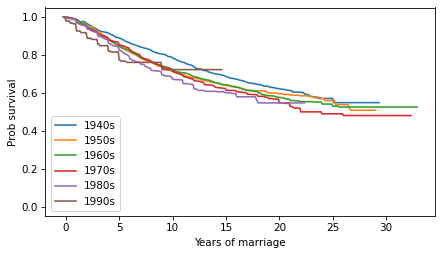

<IPython.core.display.Javascript object>

In [204]:
# Solution

# People born in the 1940s were the least likely to divorce
# Later generations have higher divorce rates. But the sample sizes
# are smaller for later generations, so it's hard to say whether the
# differences are meaningful.

for cohort, surv in surv_map.items():
    surv.plot(label=f"{cohort}s")

decorate(xlabel="Years of marriage", ylabel="Prob survival", ylim=[-0.05, 1.05])

### Exercise

In 2012, a team of demographers at the University of Southern California estimated life expectancy for people born in Sweden in the early 1800s and 1900s.
For ages from 0 to 91 years, they estimated the age-specific mortality rate, which is the fraction of people who survive until a certain age and then die at that age -- which you might recognize as the hazard function.

I used an online graph digitizer to get the data from the figure in their paper and store it in a CSV file.
Instructions for downloading the data are in the notebook for this chapter.

Data source: Beltrán-Sánchez, H., Crimmins, E. M., & Finch, C. E. (2012). Early cohort mortality predicts the rate of aging in the cohort: a historical analysis. *Journal of developmental origins of health and disease*, 3(5), 380-386.

The following cell downloads the data.

In [175]:
download(
    "https://github.com/AllenDowney/ThinkStats/raw/v3/data/mortality_rates_beltran2012.csv"
)

<IPython.core.display.Javascript object>

We can load the data like this.

In [176]:
mortality = pd.read_csv("mortality_rates_beltran2012.csv", header=[0, 1]).dropna()

<IPython.core.display.Javascript object>

The following function interpolates the data to make a hazard function with approximate mortality rates for each age from 0 to 99.

In [177]:
from scipy.interpolate import interp1d
from empiricaldist import Hazard


def make_hazard(ages, rates):
    """Make a Hazard function by interpolating a Series.

    series: Series

    returns: Hazard
    """
    interp = interp1d(ages, rates, fill_value="extrapolate")
    xs = np.arange(0, 100)
    ys = np.exp(interp(xs))
    return Hazard(ys, xs)

<IPython.core.display.Javascript object>

Now we can make a `Hazard` object like this.

In [178]:
ages = mortality["1800", "X"].values
rates = mortality["1800", "Y"].values
hazard = make_hazard(ages, rates)

<IPython.core.display.Javascript object>

Here's what the mortality rates look like.

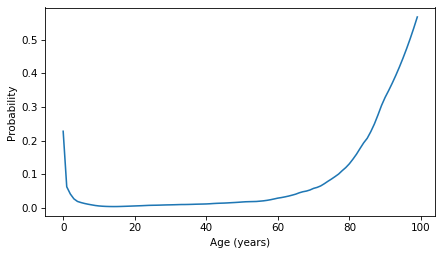

<IPython.core.display.Javascript object>

In [179]:
hazard.plot()

decorate(xlabel="Age (years)", ylabel="Probability")

Use `make_surv` to make a survival function based on these rates, and `make_cdf` to compute the corresponding CDF.
Plot the results.

Then use `make_pmf` to make the PMF of the distribution of lifetimes and plot it.
Finally, use `compute_pmf_remaining` to compute the average remaining lifetime at each age from 0 to 99.
Plot the result.

In the remaining lifetime curve, you should see a counterintuitive pattern -- for the first few years of life, remaining lifetime increases.
Because infant mortality was so high in the early 1800s, an older child was expected to live longer than a younger child.
After about age 5, life expectancy returns to the pattern we expect -- young people are expected to live longer than old people.

If you are interested in this topic, you might like Chapter 5 of my book, *Probably Overthinking It*, which includes similarly counterintuitive results from many areas of statistics. 

Available from <https://probablyoverthinking.it>.

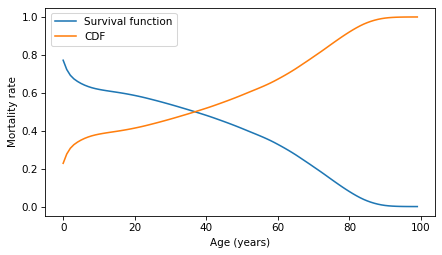

<IPython.core.display.Javascript object>

In [180]:
# Solution

surv = hazard.make_surv()
cdf = surv.make_cdf()

surv.plot(label="Survival function")
cdf.plot(label="CDF")

decorate(xlabel="Age (years)", ylabel="Mortality rate")

In [181]:
# Solution

pmf = cdf.make_pmf()
pmf.sum()

0.9999752374504388

<IPython.core.display.Javascript object>

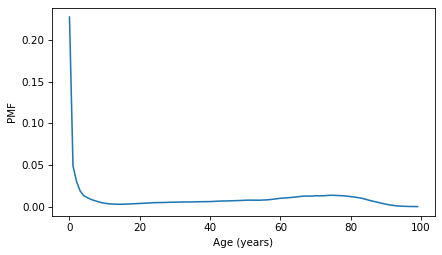

<IPython.core.display.Javascript object>

In [182]:
# Solution

pmf.plot()

decorate(xlabel="Age (years)", ylabel="PMF")

In [183]:
# Solution

index = range(0, 100)
expected = pd.Series(index=index)

for t in index:
    pmf_remaining = compute_pmf_remaining(pmf, t)
    expected[t] = pmf_remaining.mean()

<IPython.core.display.Javascript object>

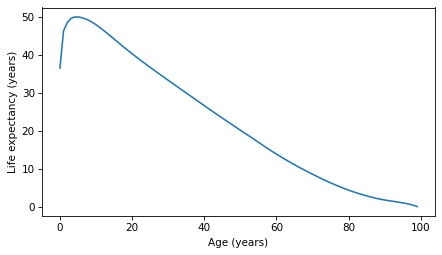

<IPython.core.display.Javascript object>

In [184]:
# Solution

expected.plot()

decorate(xlabel="Age (years)", ylabel="Remaining life expectancy (years)")

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)